In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os
import time
import pandas as pd

from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline
from netunicorn.library.tasks.capture.tcpdump import StartCapture, StopNamedCapture
from netunicorn.library.tasks.upload.fileio import UploadToFileIO
from netunicorn.library.tasks.upload.webdav import UploadToWebDav
from netunicorn.library.tasks.basic import SleepTask
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTest
from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideo
from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideo
from netunicorn.library.tasks.video_watchers.twitch_watcher import WatchTwitchStream

## Choosing a Device to use for this Lab

#### Set netUnicorn API Credentials

In [2]:
NETUNICORN_ENDPOINT = os.environ.get('NETUNICORN_ENDPOINT', 'https://pinot.cs.ucsb.edu/netunicorn')
NETUNICORN_LOGIN = os.environ.get('NETUNICORN_LOGIN', '')       # substitute your login here
NETUNICORN_PASSWORD = os.environ.get('NETUNICORN_PASSWORD', '') # substitue your password here

In [3]:
client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
print("Health Check: {}".format(client.healthcheck()))
nodes = client.get_nodes()
print(nodes)

Health Check: True
[[snl-server-5, atopnuc-84:47:09:1b:00:3c, atopnuc-84:47:09:17:c1:8d, atopnuc-84:47:09:17:c0:f6, atopnuc-84:47:09:17:c0:57, atopnuc-84:47:09:17:c8:0c, atopnuc-84:47:09:17:c4:83, atopnuc-84:47:09:17:c1:df, atopnuc-84:47:09:16:b6:cf, raspi-e4:5f:01:a7:b1:c1, raspi-e4:5f:01:72:a2:eb, raspi-e4:5f:01:56:d9:a3, raspi-e4:5f:01:ac:e5:4b, raspi-e4:5f:01:a0:34:a5, raspi-e4:5f:01:6f:ee:14, raspi-e4:5f:01:8d:f5:95, raspi-e4:5f:01:75:6a:df, raspi-e4:5f:01:6f:ef:0a, raspi-e4:5f:01:9c:24:87, raspi-e4:5f:01:a0:4f:96, raspi-e4:5f:01:9b:84:c4, raspi-e4:5f:01:8e:27:aa, raspi-e4:5f:01:75:54:ec, raspi-e4:5f:01:a0:50:5f, raspi-e4:5f:01:9c:20:81, raspi-e4:5f:01:75:54:04, raspi-e4:5f:01:96:01:e8, raspi-e4:5f:01:8c:8a:41, raspi-e4:5f:01:a0:4f:c5, raspi-e4:5f:01:78:6f:2e, raspi-e4:5f:01:a0:32:5f, raspi-e4:5f:01:a7:b1:e5, raspi-e4:5f:01:9b:85:9c, raspi-e4:5f:01:72:a2:35, raspi-e4:5f:01:72:a3:1c, raspi-e4:5f:01:88:c4:99, raspi-e4:5f:01:a0:21:49, raspi-e4:5f:01:a0:4e:31, raspi-e4:5f:01:84:7f:76,

#1- raspi-e4:5f:01:8d:f5:95  
#2- raspi-e4:5f:01:78:6f:2e   
#3- raspi-e4:5f:01:a0:32:5f   
#4- raspi-e4:5f:01:a7:b1:e5   
#5- raspi-e4:5f:01:84:7f:76   
#6- raspi-e4:5f:01:ad:c9:3f   
#7- raspi-e4:5f:01:9c:25:7d   
#8- raspi-e4:5f:01:56:d8:f3   
#9- raspi-e4:5f:01:ac:ed:5b   
#10- raspi-e4:5f:01:ad:c9:04   

In [ ]:
working_node = '<set this to your node>'

## Collecting Network Data for Video Streaming
In this pipeline we will be collecting packet captures while streaming video for Twitch / Vimeo. We will also have to upload these pcaps to retreive them. Generally, we shouldn't print the contents of these pcaps and forward the output so we will define a task to upload the pcaps to the lab server.

### Instructions for Uploading PCAPS to lab server
Use the `UploadToWebDav` task from `netunicorn.library.tasks.upload.webdav`  
    - filepaths is a Set of filenames to upload to the endpoint  
    - endpoint is where we will upload the files  
        - http://snl-server-5.cs.ucsb.edu/cs190n/<netunicorn_login\>/<any path you want\>  
        - Corresponding file will be at snl-server-5.cs.ucsb.edu:/mnt/md0/cs190n/<netunicorn_login\>/<path you specified\>/<container_id\>/<filepath\>  
    - username/password: `uploader`/`uploader`  

In [ ]:
pipeline = Pipeline()

# Flag to enable early stopping -- so if any task fails pipeline would go on working
# pipeline.early_stopping = False

# Generate data for Vimeo
pipeline.then(StartCapture(filepath="/tmp/vimeo_capture.pcap", name="capture1"))
for _ in range(5):
    pipeline.then(WatchVimeoVideo("https://vimeo.com/375468729", 10))
pipeline.then(StopNamedCapture(start_capture_task_name="capture1"))

pipeline.then(SleepTask(2))

# Generate data for Twitch
pipeline.then(StartCapture(filepath="/tmp/twitch_capture.pcap", name="capture2"))
for _ in range(5):
    pipeline.then(WatchTwitchStream("https://www.twitch.tv/shroud", 10))
pipeline.then(StopNamedCapture(start_capture_task_name="capture2"))

# Upload Data
pipeline.then(UploadToWebDav(filepaths={"/tmp/vimeo_capture.pcap"}, endpoint="http://snl-server-5.cs.ucsb.edu/cs190n/team_spdy/vimeo_capture", username="uploader", password="uploader"))
pipeline.then(UploadToWebDav(filepaths={"/tmp/twitch_capture.pcap"}, endpoint="http://snl-server-5.cs.ucsb.edu/cs190n/team_spdy/twitch_capture", username="uploader", password="uploader"))



In [ ]:
client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
print("Health Check: {}".format(client.healthcheck()))
nodes = client.get_nodes()
print(nodes)

In [ ]:
working_nodes = nodes.filter(lambda node: node.name.startswith(working_node)).take(1)

# Creating the experiment
experiment = Experiment().map(pipeline, working_nodes)
print(experiment)

### Installing Libraries vs Docker Image

In [ ]:
for line in experiment[0].environment_definition.commands:
    print(line)

We can also use a predefined Docker image which will avoid installing any libraries.

In [ ]:
from netunicorn.base import DockerImage
for deployment in experiment:
    # you can explore the image on the DockerHub
    deployment.environment_definition = DockerImage(image='speeeday/chromium-speedtest:0.3.1')

In [ ]:
experiment_label = "video_watchers_example_speeeday"

Now we can prepare the experiment, check for any errors and execute.

In [ ]:
try:
    client.delete_experiment(experiment_label)
except RemoteClientException:
    pass

client.prepare_experiment(experiment, experiment_label)

while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status == ExperimentStatus.READY:
        break
    time.sleep(20)

In [ ]:
for deployment in client.get_experiment_status(experiment_label).experiment:
    print(f"Prepared: {deployment.prepared}, error: {deployment.error}")

In [ ]:
client.start_execution(experiment_label)

while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.RUNNING:
        break
    time.sleep(20)

In [ ]:
from returns.pipeline import is_successful

for report in info.execution_result:
    print(f"Node name: {report.node.name}")
    print(f"Error: {report.error}")

    result, log = report.result  # report stores results of execution and corresponding log
    
    # result is a returns.result.Result object, could be Success of Failure
    print(f"Result is: {type(result)}")
    data = result.unwrap() if is_successful(result) else result.failure()
    for key, value in data.items():
        print(f"{key}: {value}")

    # we also can explore logs
    for line in log:
        print(line.strip())
    print()

Now we can verify that our files are properly created on the server.

## Preprocessing Network Data
Now that we've collected data, we need to preprocess the data from packet captures to a format that we can use to train our model. This is also the stage where we can compute new features for our model. For example, we can compute video streaming metrics from the raw data such as the number / size of the chunks to use as input features to a learning problem such as predicting the resolution of the video.
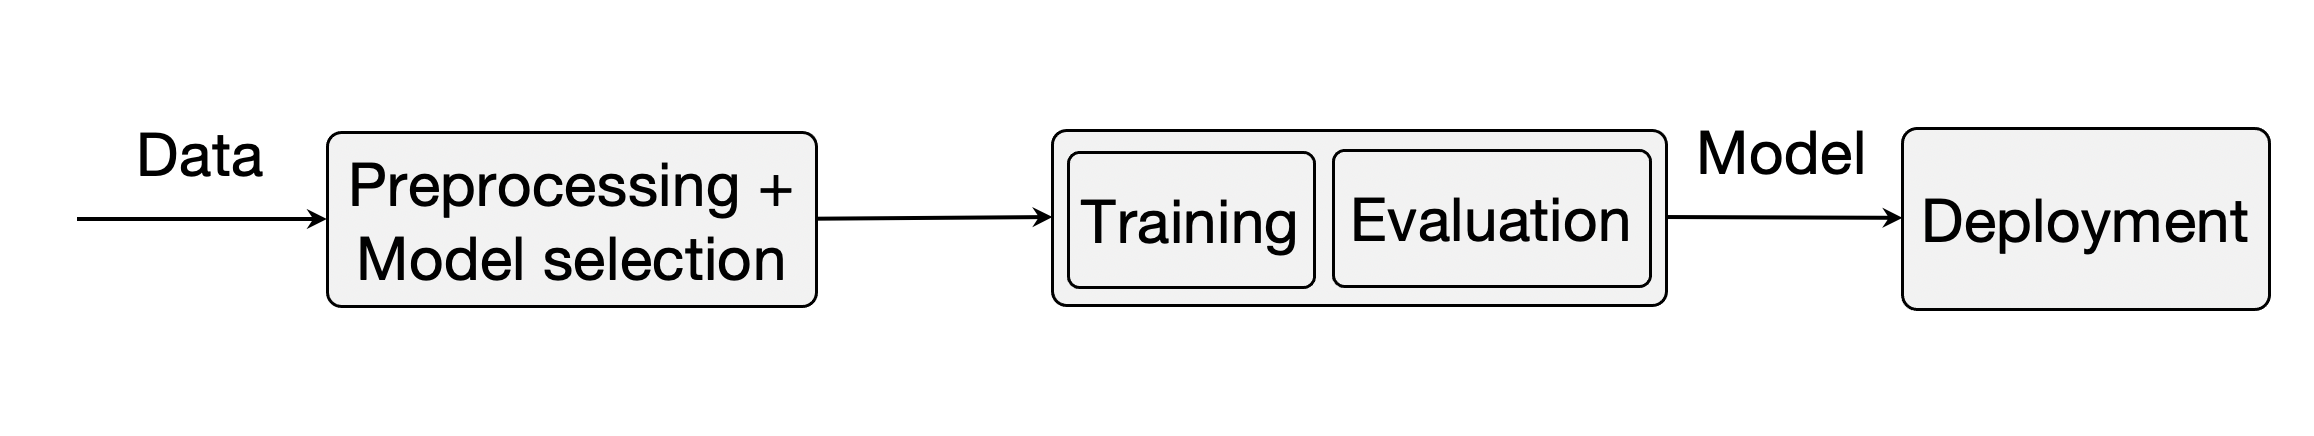

We have a few options to help us with preprocessing our data to convert into a CSV format that we can work with existing ML tools.
#### CICFlowmeter
CICFlowmeter is a tool that extract flow-level statistics from the raw pcaps. We've provided a Docker image that you can use to run this program on your pcaps.

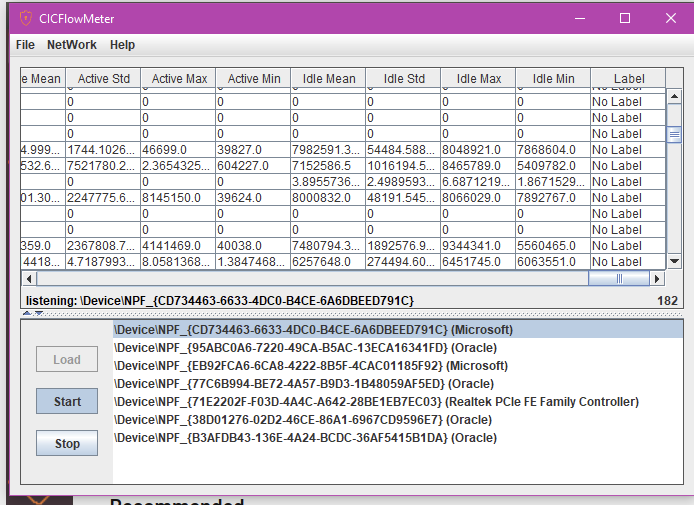

#### Using the Docker Image
`docker run`    

`-v <local_filepath>:/tmp/<filename>` - mount the pcap you want to convert into the tmp directory of the Docker container  

`-v /mnt/md0/cs190n/<NETUNICORN_LOGIN>:/tmp/output` - mount your upload folder into the tmp directory of the Docker container for retreiving output  

`--rm` - remove the Docker container when it is finished running  

`pinot.cs.ucsb.edu/cicflowmeter:latest` - name of the cicflowmeter docker image    

`/tmp/<filename>` - name of the pcap to convert to CSV (inside the Docker container)  

`/tmp/output` - name of the output directory (inside the Docker container)   

Let's convert both of these pcaps to CSV

### Using tshark to extract fields from a pcap

#### Create a header row

```echo "ts_server	ts_switch	sIP	tcp_sPort	udp_sPort	dIP	tcp_dPort	udp_dPort	ip_tot_len	ip_hdr_len	ip_proto	tcp_flags	tcp_seq	tcp_ack	tcp_hdr_len	udp_tot_len	retransmission	tcp_options_ts	tcp_options_tsecr	hostname	ssrc_id	rtp_ptype	rtp_seq	ts_rtp >> <output_filepath>.csv```

#### Extract Fields

List of fields to extract can be found from wireshark docs. [IPv4](https://www.wireshark.org/docs/dfref/i/ip.html) [TCP](https://www.wireshark.org/docs/dfref/t/tcp.html) [UDP](https://www.wireshark.org/docs/dfref/u/udp.html)

```tshark -r <pcap_name> -T fields -E separator=/t -e frame.time_epoch -e eth.dst -e ip.src -e tcp.srcport -e udp.srcport -e ip.dst -e tcp.dstport -e udp.dstport -e ip.len -e ip.hdr_len -e ip.proto -e tcp.flags -e tcp.seq_raw -e tcp.ack_raw -e tcp.hdr_len -e udp.length -e tcp.analysis.retransmission -e tcp.options.timestamp.tsval -e tcp.options.timestamp.tsecr -e tls.handshake.extensions_server_name >> <output_filepath>.csv```

Try it out on the same pcaps.

Now we can import these CSVs into pandas

In [ ]:
df_twitch = pd.read_csv("/mnt/md0/cs190n/team_spdy/capture_twitch.pcap_Flow.csv")
df_vimeo = pd.read_csv("/mnt/md0/cs190n/team_spdy/capture_vimeo.pcap_Flow.csv")

print(df_twitch.columns)   # these are all columns that CICFlowMeter uses

Can read about the field names in CIC Flow Meter [here](https://github.com/ahlashkari/CICFlowMeter/blob/master/ReadMe.txt)

To simplify, we will use a subset of features that represent a typical video streaming flow.

In [ ]:
features = [
    "Label",
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/s",
    "Flow IAT Mean",
    "Bwd IAT Mean",
    "Down/Up Ratio",
    "Active Mean",
    "Idle Mean"
]

Let's clean YouTube and Vimeo traffic. We will mark all connections with more than 30 forward or backward packets as video stream connections, and will drop extra UDP traffic not related to streaming.

In [ ]:
df_twitch['Label'] = 'other'
df_twitch.loc[(df_twitch['Total Fwd Packet'] > 30) | (df_twitch['Total Bwd packets'] > 30), 'Label'] = 'twitch'  
df_twitch = df_twitch.drop(df_twitch[(df_twitch['Protocol'] == 17) & (df_twitch['Label'] != 'twitch')].index)

In [ ]:
df_vimeo['Label'] = 'other'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'
df_vimeo = df_vimeo.drop(df_vimeo[(df_vimeo['Protocol'] == 17) & (df_vimeo['Label'] != 'vimeo')].index)

Now we can concat these two dataframes together and leave only features that we need

In [ ]:
df = pd.concat([df_twitch, df_vimeo], ignore_index=True)
df = df[features]
df = df.dropna()  # remove rows with Nones

In [ ]:
# Inspect the data
df.head()

## Classifier Training
We can use the sci-kit learn python module for training a classifier.   
There a number of different options we can use for a classifer listed [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)   
Specifically we will use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)   

Random Forests / Decision Trees are great for classification problems. Simply tries to fit a set of thresholds answering yes/no questions about a certain feature.

In [ ]:
%pip install scikit-learn

In [ ]:
# required imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [ ]:
# separate the data frame to features and answers
target_variable = 'Label'
train_features = list(set(df.columns) - {target_variable})
x_train = df[train_features]
y_train = df[target_variable]

In [ ]:
# and start training a classifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

We see that our decision tree is able to classify all the data we trained it with using a single tree. But how will this model perform on a new set of traces that it hasn't been trained with? What about different set of features?

Last Note: Focus on understanding the whole processing of capturing data to building a model. High accuracy models generally require lots of data as well as domain expertise. It's okay if the accuracy is low for your project but you should enable a closed-loop pipeline going from data collection to a trained model.